In [1]:
import re, os, numpy as np, pandas as pd, tensorflow as tf, keras, cv2
from glob import glob
import matplotlib.pyplot as plt                        
%matplotlib inline         

C:\Users\Rohit\Anaconda3\envs\aind\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
imgpath = 'images/sample_human_output.png'
img = cv2.imread(imgpath)
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]
dog_names_dict = {int(item[16:19])-1: item[20:-1].replace('_',' ').title() for item in sorted(glob("dogImages/train/*/"))}

In [3]:
def detect_human_faces(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')
    return face_cascade.detectMultiScale(gray)

def draw_faces(img):
    for (x,y,w,h) in detect_human_faces(img):
        # add bounding box to color image
        cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # display the image, along with bounding box
    plt.imshow(cv_rgb)
    plt.show()
    
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    return len(detect_human_faces(img)) > 0

In [4]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

In [5]:
from keras.preprocessing import image                  
from keras.applications.resnet50 import preprocess_input, decode_predictions

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in img_paths]
    return np.vstack(list_of_tensors)

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

In [6]:
bottleneck_features = np.load('bottleneck_features/DogResnet50Data.npz')
train_Resnet50 = bottleneck_features['train']
valid_Resnet50 = bottleneck_features['valid']
test_Resnet50 = bottleneck_features['test']

In [7]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model_Resnet50 = Sequential()
model_Resnet50.add(GlobalAveragePooling2D(input_shape = train_Resnet50.shape[1:]))
model_Resnet50.add(Dense(512))
model_Resnet50.add(Dense(256))
model_Resnet50.add(Dense(133, activation='softmax'))

model_Resnet50.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 133)               34181     
Total params: 1,214,597
Trainable params: 1,214,597
Non-trainable params: 0
_________________________________________________________________


In [8]:
model_Resnet50.load_weights('saved_models/weights.best.Resnet50.hdf5')

In [9]:
####### Test Accuracy of the model   ########
from keras.utils import np_utils
from sklearn.datasets import load_files       

def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

test_files, test_targets = load_dataset('dogImages/test')

# get index of predicted dog breed for each image in test set
Resnet50_predictions = [np.argmax(model_Resnet50.predict(np.expand_dims(feature, axis=0))) for feature in test_Resnet50]

# report test accuracy
test_accuracy = 100*np.sum(np.array(Resnet50_predictions)==np.argmax(test_targets, axis=1))/len(Resnet50_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 82.6555%


In [10]:
from extract_bottleneck_features import *

def Resnet50_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_Resnet50(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = model_Resnet50.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names_dict[np.argmax(predicted_vector)]

In [11]:
Resnet50_predict_breed('images/Curly-coated_retriever_03896.jpg')

'Curly-Coated Retriever'

In [12]:
import matplotlib.image as mpimg
import random
def dog_breed_classifier(img):
    read_img = mpimg.imread(img)
    plt.imshow(read_img)
    plt.show()
    predicted_breed = Resnet50_predict_breed(img)
    print('You look like', ('an' if (predicted_breed[0] in {'a','e','i','o','u','A','E','I','O','U'}) else 'a'), predicted_breed)
    dogpaths = glob([i for i in glob("dogImages/test/*/") if predicted_breed in i][0]+'*')
    random.shuffle(dogpaths)
    print('Here are some', predicted_breed, 'pictures for your reference...')
    read_img = [mpimg.imread(dogpaths[i]) for i in range(3)]
    f, axarr = plt.subplots(1,3)
    axarr[0].imshow(read_img[0])
    axarr[1].imshow(read_img[1])
    axarr[2].imshow(read_img[2])
    plt.show()
    print('-------------------------------------------------------------------\n')

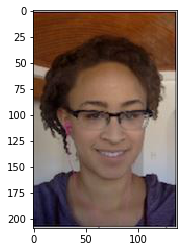

You look like a Chow_chow
Here are some Chow_chow pictures for your reference...


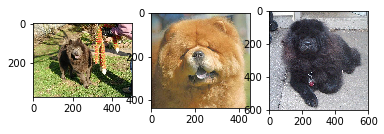

-------------------------------------------------------------------



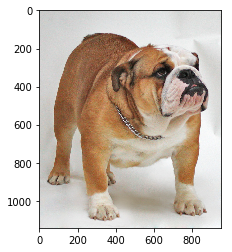

You look like a Bulldog
Here are some Bulldog pictures for your reference...


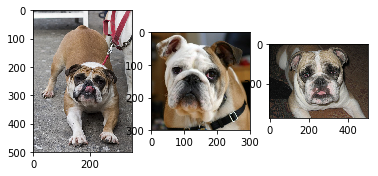

-------------------------------------------------------------------



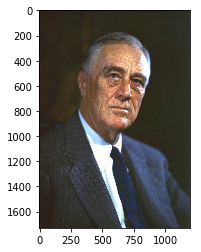

You look like an American_foxhound
Here are some American_foxhound pictures for your reference...


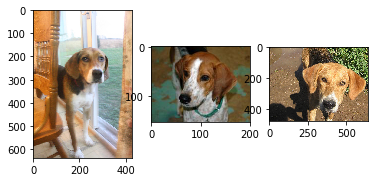

-------------------------------------------------------------------



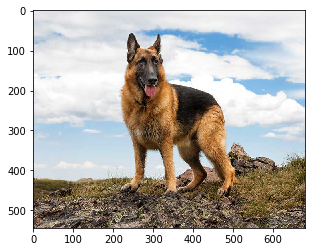

You look like a German_shepherd_dog
Here are some German_shepherd_dog pictures for your reference...


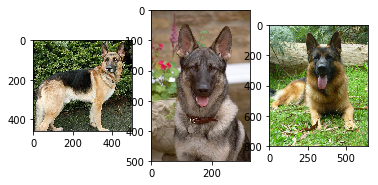

-------------------------------------------------------------------



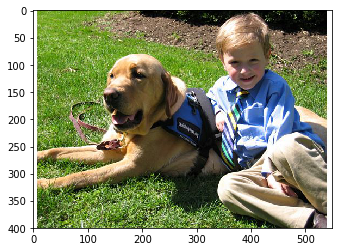

You look like a Bloodhound
Here are some Bloodhound pictures for your reference...


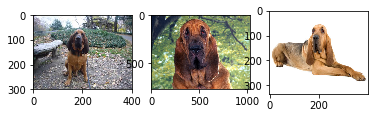

-------------------------------------------------------------------



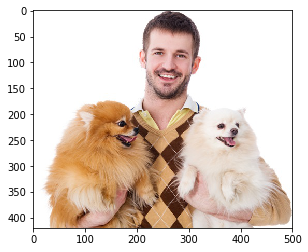

You look like a Pomeranian
Here are some Pomeranian pictures for your reference...


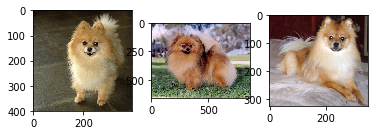

-------------------------------------------------------------------



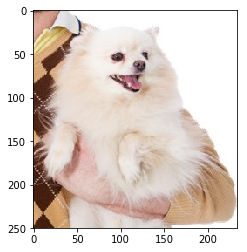

You look like an American_eskimo_dog
Here are some American_eskimo_dog pictures for your reference...


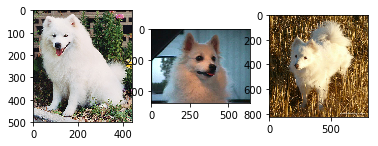

-------------------------------------------------------------------



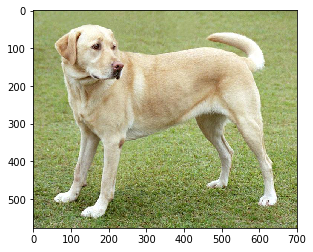

You look like an Anatolian_shepherd_dog
Here are some Anatolian_shepherd_dog pictures for your reference...


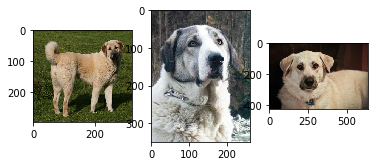

-------------------------------------------------------------------



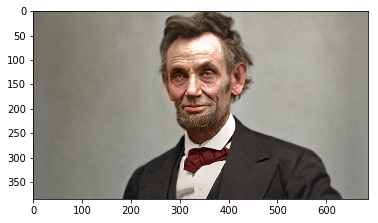

You look like a Lowchen
Here are some Lowchen pictures for your reference...


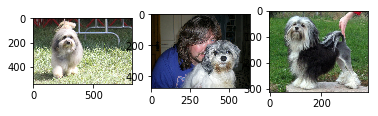

-------------------------------------------------------------------



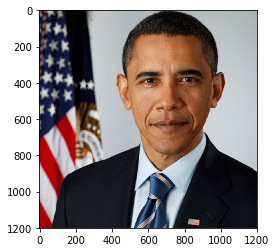

You look like an American_foxhound
Here are some American_foxhound pictures for your reference...


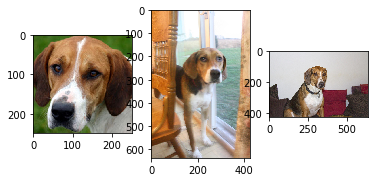

-------------------------------------------------------------------



In [28]:
from glob import glob
user_image_paths = glob('user_images\\*')
_ = [dog_breed_classifier(i) for i in user_image_paths]

In [51]:
sorted(glob("dogImages/train/*/"))

['dogImages/train\\001.Affenpinscher\\',
 'dogImages/train\\002.Afghan_hound\\',
 'dogImages/train\\003.Airedale_terrier\\',
 'dogImages/train\\004.Akita\\',
 'dogImages/train\\005.Alaskan_malamute\\',
 'dogImages/train\\006.American_eskimo_dog\\',
 'dogImages/train\\007.American_foxhound\\',
 'dogImages/train\\008.American_staffordshire_terrier\\',
 'dogImages/train\\009.American_water_spaniel\\',
 'dogImages/train\\010.Anatolian_shepherd_dog\\',
 'dogImages/train\\011.Australian_cattle_dog\\',
 'dogImages/train\\012.Australian_shepherd\\',
 'dogImages/train\\013.Australian_terrier\\',
 'dogImages/train\\014.Basenji\\',
 'dogImages/train\\015.Basset_hound\\',
 'dogImages/train\\016.Beagle\\',
 'dogImages/train\\017.Bearded_collie\\',
 'dogImages/train\\018.Beauceron\\',
 'dogImages/train\\019.Bedlington_terrier\\',
 'dogImages/train\\020.Belgian_malinois\\',
 'dogImages/train\\021.Belgian_sheepdog\\',
 'dogImages/train\\022.Belgian_tervuren\\',
 'dogImages/train\\023.Bernese_mountain_

In [66]:
dog_names[54]

'Curly-coated_retriever'

In [70]:
webstring = r'https://www.google.com/search?q=Labrador+Retriever&tbm=isch'

In [30]:
dog_names[5]

'American_eskimo_dog'

In [42]:
s = dog_dict[10]

In [44]:
s.replace('_',' ').title()

'Australian Cattle Dog'

In [46]:
dog_dict

{0: 'Affenpinscher',
 1: 'Afghan Hound',
 2: 'Airedale Terrier',
 3: 'Akita',
 4: 'Alaskan Malamute',
 5: 'American Eskimo Dog',
 6: 'American Foxhound',
 7: 'American Staffordshire Terrier',
 8: 'American Water Spaniel',
 9: 'Anatolian Shepherd Dog',
 10: 'Australian Cattle Dog',
 11: 'Australian Shepherd',
 12: 'Australian Terrier',
 13: 'Basenji',
 14: 'Basset Hound',
 15: 'Beagle',
 16: 'Bearded Collie',
 17: 'Beauceron',
 18: 'Bedlington Terrier',
 19: 'Belgian Malinois',
 20: 'Belgian Sheepdog',
 21: 'Belgian Tervuren',
 22: 'Bernese Mountain Dog',
 23: 'Bichon Frise',
 24: 'Black And Tan Coonhound',
 25: 'Black Russian Terrier',
 26: 'Bloodhound',
 27: 'Bluetick Coonhound',
 28: 'Border Collie',
 29: 'Border Terrier',
 30: 'Borzoi',
 31: 'Boston Terrier',
 32: 'Bouvier Des Flandres',
 33: 'Boxer',
 34: 'Boykin Spaniel',
 35: 'Briard',
 36: 'Brittany',
 37: 'Brussels Griffon',
 38: 'Bull Terrier',
 39: 'Bulldog',
 40: 'Bullmastiff',
 41: 'Cairn Terrier',
 42: 'Canaan Dog',
 43: '